OUTCOME
Blue     8057
Red      8057
NC/NC     162
D/D       118
Name: count, dtype: int64
OUTCOME
Blue     8057
Red      8057
NC/NC     162
D/D       118
Name: count, dtype: int64
Accuracy: 0.6292
Classification Report:
              precision    recall  f1-score   support

         Red       0.61      0.65      0.63      1571
        Blue       0.65      0.61      0.63      1652

    accuracy                           0.63      3223
   macro avg       0.63      0.63      0.63      3223
weighted avg       0.63      0.63      0.63      3223

Prediction: Ilia Topuria (Blue) would win with confidence 65.18%
['red_StrikesLandedPerMin', 'red_StrikesAbsorbedPerMin', 'red_TakedownsPer15Min', 'red_OpponentTakedownsPer15Min', 'red_SubmissionsPer15Min', 'red_ControlPer15Min', 'red_StrikingAccuracyPct', 'red_StrikeDefencePct', 'red_TakedownAccuracyPct', 'red_TakedownDefencePct', 'blue_StrikesLandedPerMin', 'blue_StrikesAbsorbedPerMin', 'blue_TakedownsPer15Min', 'blue_OpponentTakedownsPer15Min', '

C:\Users\craig\AppData\Local\Temp\ipykernel_400\1449788966.py:149: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  original_X = original_X.fillna(0)


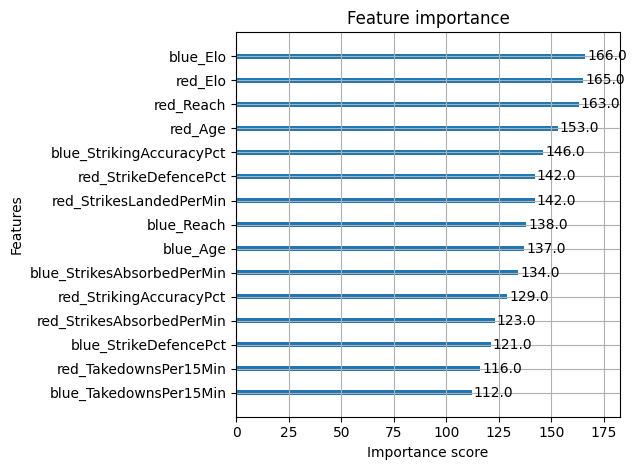

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import pickle


# Load data
df = pd.read_csv("../processed_data/fight_results_shuffled.csv")

fighters_df=pd.read_csv("../processed_data/fighter_averages.csv")

# Drop unsupported columns
#print(df.columns.tolist())

from sklearn.utils import resample

print(df["OUTCOME"].value_counts())

red_wins = df[df["OUTCOME"] == "Red"]
blue_wins = df[df["OUTCOME"] == "Blue"]

min_len = min(len(red_wins), len(blue_wins))

#df = pd.concat([
#    red_wins.sample(min_len, random_state=42),
#    blue_wins.sample(min_len, random_state=42)
#])

print(df["OUTCOME"].value_counts())

df.columns = df.columns.str.strip()

df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['red_DOB'] = pd.to_datetime(df['red_DOB'], errors='coerce')
df['blue_DOB'] = pd.to_datetime(df['blue_DOB'], errors='coerce')

# Calculate ages at fight date (in years)
df['red_Age'] = (df['DATE'] - df['red_DOB']).dt.days // 365
df['blue_Age'] = (df['DATE'] - df['blue_DOB']).dt.days // 365

df = df.drop(columns=["DATE", "red_DOB", "blue_DOB"])



# Convert to category dtype
categorical_cols = ["METHOD", "red_Stance", "blue_Stance", "red_Name", "blue_Name"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

# Filter target and encode
df = df[df["OUTCOME"].isin(["Red", "Blue"])].copy()
df["OUTCOME"] = df["OUTCOME"].map({"Red": 0, "Blue": 1})


# Features and target
X = df.drop(columns=["OUTCOME", "METHOD", "red_Name", "blue_Name",], axis=1) # "red_Name", "blue_Name", "red_Elo", "blue_Elo"
y = df["OUTCOME"]

# Train/test split
X_train, original_X, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Train XGBoost with native categorical support
model = XGBClassifier(
    
    eval_metric="logloss",
    enable_categorical=True,
    n_estimators=500,     # fewer trees
    max_depth=3,          # shallower trees
    learning_rate=0.1,    # slightly faster learning
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=1,
    reg_lambda=1
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(original_X)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Red", "Blue"]))



# Plot importance
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, max_num_features=15)
plt.tight_layout()
#plt.show()



def create_features_from_df(fighter1_name, fighter2_name, df):
    red_stats = df[df["Name"] == fighter1_name]
    blue_stats = df[df["Name"] == fighter2_name]

    if red_stats.empty or blue_stats.empty:
        raise ValueError("One or both fighter names not found in the dataframe.")

    # Drop the 'Name' column to keep only features
    red_features = red_stats.drop(columns=["Name"]).iloc[0]
    blue_features = blue_stats.drop(columns=["Name"]).iloc[0]

    # Prefix features
    red_features.index = ["red_" + str(col) for col in red_features.index]
    blue_features.index = ["blue_" + str(col) for col in blue_features.index]

    # Combine into one feature vector
    combined_features = pd.concat([red_features, blue_features])

    # Convert to DataFrame with one row
    return combined_features.to_frame().T



fighter1 = "Ilia Topuria"
fighter2 = "Ilia Topuria"

original_X = create_features_from_df(fighter1, fighter2, fighters_df)

# Convert numeric columns to floats
numeric_cols = [
    'red_StrikesLandedPerMin', 'red_StrikesAbsorbedPerMin', 
    'red_OpponentTakedownsPer15Min','blue_OpponentTakedownsPer15Min', 
    'red_SubmissionsPer15Min', 'red_ControlPer15Min', 'red_StrikingAccuracyPct', 'red_StrikeDefencePct',
    'red_TakedownAccuracyPct', 'red_TakedownDefencePct', 'blue_StrikesLandedPerMin', 'blue_StrikesAbsorbedPerMin', 
    'blue_TakedownsPer15Min', 'blue_SubmissionsPer15Min', 'blue_ControlPer15Min', 'blue_StrikingAccuracyPct', 
    'blue_StrikeDefencePct', 'blue_TakedownAccuracyPct', 'blue_TakedownDefencePct', 
    'red_Height', 'red_Weight', 'red_Reach', 'blue_Height', 'blue_Weight', 'blue_Reach', 
    'red_Elo', 'blue_Elo'
]
for col in numeric_cols:
    if col in original_X.columns:
        original_X[col] = pd.to_numeric(original_X[col], errors='coerce')

# Handle categorical (drop or encode)
original_X = original_X.drop(columns=['red_Stance', 'blue_Stance'], errors='ignore')

# Fill NaNs
original_X = original_X.fillna(0)

# Ensure column order matches model input
original_X = original_X.reindex(columns=model.feature_names_in_, fill_value=0)

# Now predict
prediction = model.predict(original_X)[0]
confidence = model.predict_proba(original_X)[0].max()


winner_name = fighter1 if prediction == 0 else fighter2

print(f"Prediction: {winner_name} ({'Red' if prediction == 0 else 'Blue'}) would win with confidence {confidence:.2%}")
print(model.get_booster().feature_names)
print(original_X.columns.tolist())


with open("../models/ufc_fight_predictor.pkl", "wb") as f:
    pickle.dump(model, f)